In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import random
import cv2
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)

In [2]:
tf.__version__

'2.4.1'

In [3]:
tf.test.is_gpu_available()

True

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
os.mkdir('/kaggle/working/saved_models')
os.mkdir('/kaggle/working/logs')

In [6]:
def rel_to_abs_path(csv_file = 'train.csv'):
    csv = '/kaggle/input/nih-chest-xray-dataset-trainvaltest-labelscsv/' + csv_file
    fol_list = [f for f in os.listdir('/kaggle/input/data') if f[:6] == 'images']
    
    data = pd.read_csv(csv)
    
    for folder in fol_list:
        append_front = os.path.join(os.path.join('/kaggle/input/data',folder),'images')
        fil_list = os.listdir(append_front)
        for i in range(len(data)):
            if data['Image'].loc[i] in fil_list:
                new_path = os.path.join(append_front,data['Image'].loc[i])
                data['Image'].loc[i] = new_path
                
    data.to_csv(os.path.join('/kaggle/working',csv_file),index = False)
    print(f'{csv_file} saved in working directory!')

In [7]:
train_df = pd.read_csv('/kaggle/input/nih-dataset-with-path/train.csv')
val_df = pd.read_csv('/kaggle/input/nih-dataset-with-path/val.csv')
test_df = pd.read_csv('/kaggle/input/nih-dataset-with-path/test.csv')

In [8]:
train_df.head()

,Image,Patient ID,Fibrosis,Mass,Consolidation,Hernia,Emphysema,Cardiomegaly,Edema,Atelectasis,Effusion,Pneumonia,Infiltration,Nodule,Pleural_Thickening,Pneumothorax
0,/kaggle/input/data/images_001/images/00000001_...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,/kaggle/input/data/images_001/images/00000001_...,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,/kaggle/input/data/images_001/images/00000001_...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,/kaggle/input/data/images_001/images/00000002_...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/kaggle/input/data/images_001/images/00000004_...,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [9]:
val_df.head()

,Image,Patient ID,Fibrosis,Mass,Consolidation,Hernia,Emphysema,Cardiomegaly,Edema,Atelectasis,Effusion,Pneumonia,Infiltration,Nodule,Pleural_Thickening,Pneumothorax
0,/kaggle/input/data/images_001/images/00000009_...,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,/kaggle/input/data/images_001/images/00000020_...,20,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,/kaggle/input/data/images_001/images/00000020_...,20,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,/kaggle/input/data/images_001/images/00000020_...,20,1,0,0,0,0,0,0,0,0,0,1,0,1,0
4,/kaggle/input/data/images_001/images/00000023_...,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
test_df.head()

,Image,Patient ID,Fibrosis,Mass,Consolidation,Hernia,Emphysema,Cardiomegaly,Edema,Atelectasis,Effusion,Pneumonia,Infiltration,Nodule,Pleural_Thickening,Pneumothorax
0,/kaggle/input/data/images_001/images/00000003_...,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,/kaggle/input/data/images_001/images/00000003_...,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,/kaggle/input/data/images_001/images/00000003_...,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,/kaggle/input/data/images_001/images/00000003_...,3,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,/kaggle/input/data/images_001/images/00000003_...,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [11]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [12]:
def chk_leak(df1,df2,patient_col = 'Patient ID'):
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    
    leakage = len(patients_in_both_groups) > 0
    
    return leakage

In [13]:
print(f"Data Leakage between train and test: {chk_leak(train_df,test_df)}")
print(f"Data Leakage between train and val: {chk_leak(train_df,val_df)}")
print(f"Data Leakage between val and test: {chk_leak(val_df,test_df)}")

Data Leakage between train and test: False
Data Leakage between train and val: False
Data Leakage between val and test: False


In [14]:
def get_train_generator(df, x_col, y_cols, shuffle=True, batch_size=32, seed=1, target_w = 320, target_h = 320):
    print("Fetching Train Generator...") 
    
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    train_generator = image_generator.flow_from_dataframe(
            dataframe=df,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return train_generator

In [15]:
def get_test_and_valid_generator(valid_df, test_df, train_df, x_col, y_cols, sample_size=100, batch_size=32, seed=1, target_w = 320, target_h = 320):

    print("Getting Test and Valid Generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [16]:
train_generator = get_train_generator(train_df, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, "Image", labels)

Fetching Train Generator...
Found 69437 validated image filenames.
Getting Test and Valid Generators...
Found 69437 validated image filenames.
Found 17087 validated image filenames.
Found 25596 validated image filenames.


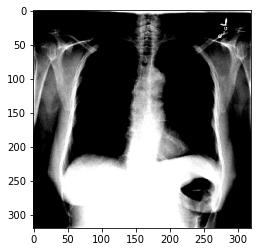

In [17]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

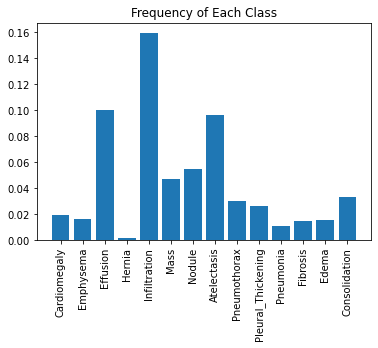

In [18]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [19]:
def compute_class_freqs(labels):
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels,axis = 0)/N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [20]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.01913965, 0.01653297, 0.10019154, 0.00151216, 0.15942509,
       0.04719386, 0.05494189, 0.0960583 , 0.03007042, 0.02619641,
       0.01052753, 0.01483359, 0.01553927, 0.03296513])

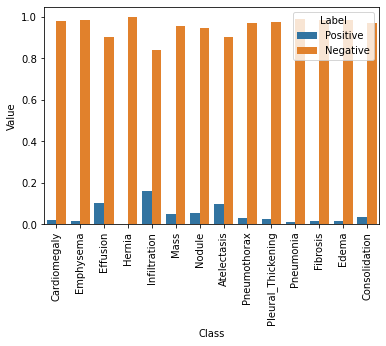

In [21]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [22]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

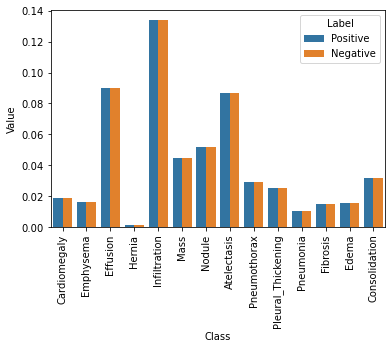

In [23]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [24]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0

        for i in range(len(pos_weights)):
            loss += -K.mean(pos_weights[i]*float(y_true[:,i])*K.log(y_pred[:,i]+epsilon) + neg_weights[i]*float(1-y_true[:,i])*K.log(1-(y_pred[:,i])+epsilon),axis = 0) 
        return loss
    return weighted_loss

In [25]:
# model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/model_weights.h5',save_freq = 2),
#     tf.keras.callbacks.TensorBoard(log_dir='./kaggle/working/logs')]

In [49]:
base_model = DenseNet121(weights='/kaggle/input/densenet-keras/DenseNet-BC-121-32-no-top.h5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

#model.compile(optimizer = 'adam',loss = 'categorical_crossentropy')

In [50]:
model.load_weights('/kaggle/input/chexnet-keras-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [32]:
# history = model.fit(train_generator, 
#                               validation_data=valid_generator,
#                               steps_per_epoch=20, 
#                               validation_steps=25, 
#                               epochs = 3,
#                                callbacks = model_callbacks)

# plt.plot(history.history['loss'])
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("Training Loss Curve")
# plt.show()

Epoch 1/3
 4/20 [=====>........................] - ETA: 8:11 - loss: 0.8931

KeyboardInterrupt: 

In [42]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

In [30]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))
type(predicted_vals)

numpy.ndarray

In [31]:
predicted_vals

array([[6.43342442e-04, 1.12820517e-08, 2.79200554e-04, ...,
        2.04834961e-07, 7.43696683e-06, 8.86904526e-12],
       [4.15783608e-04, 7.61421592e-09, 1.77307913e-04, ...,
        1.07259808e-07, 2.92034224e-06, 7.90203677e-13],
       [1.10697246e-03, 1.60867391e-08, 2.91475910e-04, ...,
        1.12090433e-07, 3.09545203e-06, 2.33626660e-12],
       ...,
       [2.44574185e-04, 1.65511282e-09, 1.20241115e-04, ...,
        1.28832099e-07, 3.07906430e-06, 1.24100383e-13],
       [3.90321744e-04, 7.40332640e-09, 2.14547472e-04, ...,
        8.84971527e-08, 4.19093794e-06, 5.81777953e-13],
       [1.75217167e-04, 9.80796422e-09, 2.05300705e-04, ...,
        6.56627179e-08, 3.41798409e-06, 1.19468635e-14]], dtype=float32)

In [32]:
np.savetxt('/kaggle/working/Test_Set_Prediction.csv',predicted_vals,delimiter=',')

In [35]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

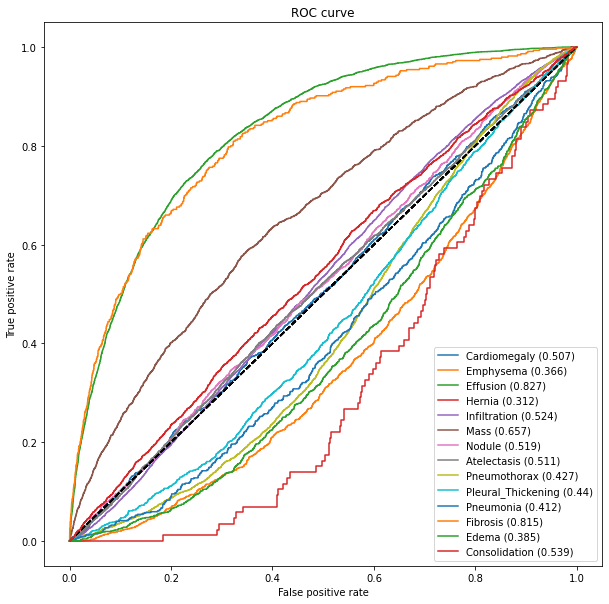

In [36]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [58]:
model.load_weights('/kaggle/input/chexnet-weights/pretrained_model.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [38]:
predicted_vals2 = model.predict(test_generator, steps = len(test_generator))
type(predicted_vals2)

numpy.ndarray

In [39]:
np.savetxt('/kaggle/working/Test_Set_Prediction_Coursera_weights.csv',predicted_vals2,delimiter=',')

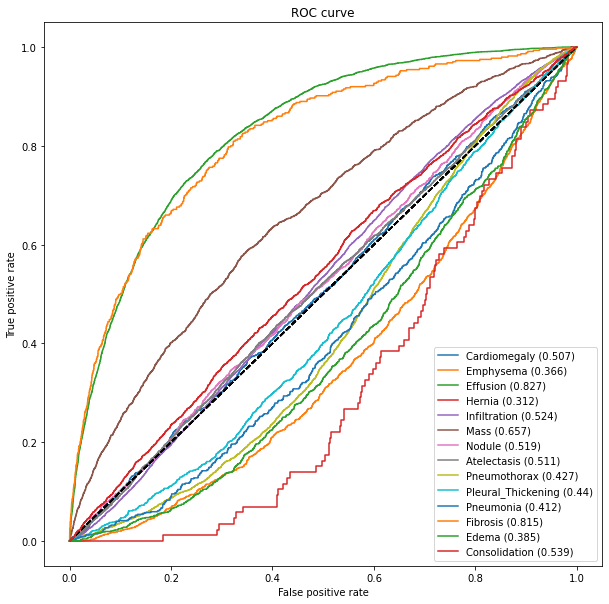

In [40]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [41]:
print(auc_rocs)

[0.5069615535663471, 0.3661798755041627, 0.8271877672661, 0.3115768554055409, 0.5240981012679486, 0.6569955086447579, 0.518634616644485, 0.510503291294286, 0.4265512010376508, 0.4404690283955376, 0.41222521191372274, 0.8149732732695693, 0.3846163621365275, 0.5391438960403488]


In [43]:
df = pd.read_csv("/kaggle/input/nih-dataset-with-path/train.csv")
IMAGE_DIR = ""

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [60]:
print(labels_to_show[3])

['Effusion' 'Fibrosis' 'Mass' 'Consolidation']


Loading original image
Generating gradcam for class Effusion
Generating gradcam for class Mass
Generating gradcam for class Fibrosis
Generating gradcam for class Consolidation


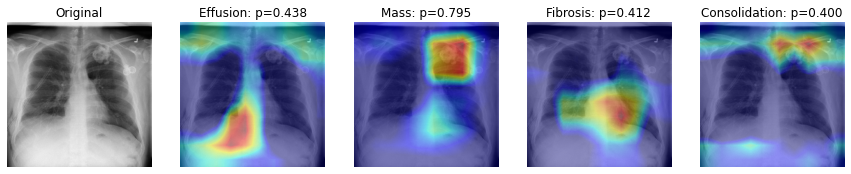

In [59]:
tf.compat.v1.disable_eager_execution()
compute_gradcam(model, '/kaggle/input/data/images_005/images/00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)